In [1]:
# packages
import re
import string
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from textblob import TextBlob
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/natasha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# data
database = pd.read_csv('FAANG_STOCK_NEWS.csv')
database.head()


,Unnamed: 0,ticker,date,time,headline,neg,neu,pos,compound
0,0,FB,2021-09-22,06:30AM,2 Growth Stocks to Buy Hand Over Fist If the M...,0.000,0.608,0.392,0.7003
1,1,FB,2021-09-22,02:23AM,UPDATE 1-Facebook wraps up deals with Australi...,0.167,0.833,0.000,-0.3400
2,2,FB,2021-09-22,12:36AM,Facebook wraps up deals with Australian media ...,0.179,0.821,0.000,-0.3400
3,3,FB,2021-09-22,12:27AM,Facebook wraps up deals with Australia media f...,0.000,1.000,0.000,0.0000
4,4,FB,2021-09-21,10:34PM,Facebook overpaid FTC fine as quid pro quo to ...,0.099,0.659,0.242,0.3818


In [3]:
database = database.drop('Unnamed: 0', axis=1)
database.shape
database.head()

,ticker,date,time,headline,neg,neu,pos,compound
0,FB,2021-09-22,06:30AM,2 Growth Stocks to Buy Hand Over Fist If the M...,0.000,0.608,0.392,0.7003
1,FB,2021-09-22,02:23AM,UPDATE 1-Facebook wraps up deals with Australi...,0.167,0.833,0.000,-0.3400
2,FB,2021-09-22,12:36AM,Facebook wraps up deals with Australian media ...,0.179,0.821,0.000,-0.3400
3,FB,2021-09-22,12:27AM,Facebook wraps up deals with Australia media f...,0.000,1.000,0.000,0.0000
4,FB,2021-09-21,10:34PM,Facebook overpaid FTC fine as quid pro quo to ...,0.099,0.659,0.242,0.3818


In [4]:
database.info() # no missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ticker    500 non-null    object 
 1   date      500 non-null    object 
 2   time      500 non-null    object 
 3   headline  500 non-null    object 
 4   neg       500 non-null    float64
 5   neu       500 non-null    float64
 6   pos       500 non-null    float64
 7   compound  500 non-null    float64
dtypes: float64(4), object(4)
memory usage: 31.4+ KB


In [5]:
database.describe()

,neg,neu,pos,compound
count,500.000000,500.000000,500.000000,500.000000
mean,0.056344,0.822262,0.121406,0.100331
std,0.111799,0.171060,0.157284,0.346107
min,0.000000,0.306000,0.000000,-0.743000
25%,0.000000,0.706750,0.000000,0.000000
50%,0.000000,0.821000,0.000000,0.000000
75%,0.000000,1.000000,0.231000,0.307000
max,0.519000,1.000000,0.694000,0.941300


In [6]:
# text processing
headline = database[['ticker', 'headline']]

def preprocess_text(text):
    # remove punctuation
    text = "".join([i for i in text if i not in string.punctuation])

    # tokenize
    tokens = re.split(r'\W+', text.lower())

    # remove stopwords
    stop_words = stopwords.words('english')
    tokens = [word for word in tokens if word not in stop_words]

    # apply stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]

    return ' '.join(tokens)

# apply to headline
headline['clean_headline'] = headline['headline'].apply(preprocess_text)

/var/folders/vj/dw0hgmzj2j57h0bng46_cd6r0000gn/T/ipykernel_5358/522122216.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  headline['clean_headline'] = headline['headline'].apply(preprocess_text)


In [7]:
# sentiment analysis
data = headline[['ticker', 'clean_headline']]

def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.subjectivity, blob.sentiment.polarity

# apply to clean_headline
data[['subjectivity', 'polarity']] = data['clean_headline'].apply(lambda x: pd.Series(get_sentiment(x)))

data.head()


,ticker,clean_headline,subjectivity,polarity
0,FB,2 growth stock buy hand fist market crash,0.0,0.000000
1,FB,updat 1facebook wrap deal australian media fir...,0.2,-0.100000
2,FB,facebook wrap deal australian media firm tv br...,0.2,-0.100000
3,FB,facebook wrap deal australia media firm tv bro...,0.4,-0.200000
4,FB,facebook overpaid ftc fine quid pro quo protec...,0.5,0.416667


In [8]:
def sentiment_label(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

data['sentiment'] = data['polarity'].apply(sentiment_label)
data.head()

,ticker,clean_headline,subjectivity,polarity,sentiment
0,FB,2 growth stock buy hand fist market crash,0.0,0.000000,Neutral
1,FB,updat 1facebook wrap deal australian media fir...,0.2,-0.100000,Negative
2,FB,facebook wrap deal australian media firm tv br...,0.2,-0.100000,Negative
3,FB,facebook wrap deal australia media firm tv bro...,0.4,-0.200000,Negative
4,FB,facebook overpaid ftc fine quid pro quo protec...,0.5,0.416667,Positive


In [9]:
data['sentiment'].value_counts()

sentiment
Neutral     295
Positive    167
Negative     38
Name: count, dtype: int64

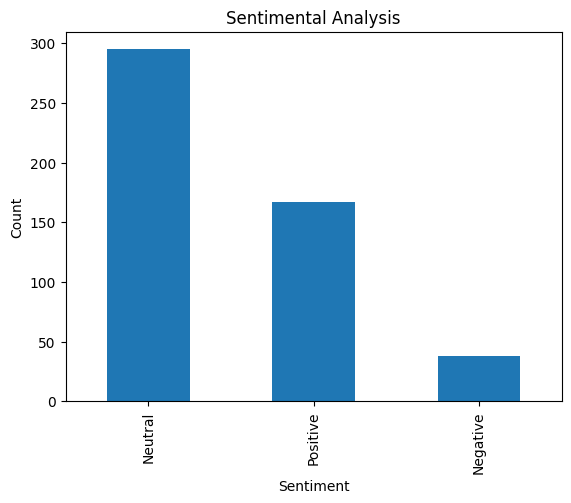

In [10]:
# plot sentiment
data['sentiment'].value_counts().plot(kind='bar')
plt.title("Sentimental Analysis")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

In [24]:
#headlines of each sentiments
sents = {sentiment: data[data.sentiment == sentiment]['clean_headline'] for sentiment in ['Positive', 'Neutral', 'Negative']}

positive_headlines = sents['Positive']
neutral_headlines = sents['Neutral']
negative_headlines = sents['Negative']

print("Positive headlines:\n", positive_headlines.head())
print("\nNeutral headlines:\n", neutral_headlines.head())
print("\nNegative headlines:\n", negative_headlines.head())


Positive headlines:
 4     facebook overpaid ftc fine quid pro quo protec...
5           gbtc stock good buy bitcoin slump big ralli
6     facebook oversight board review special rule h...
8                                5 best stock buy watch
13         top research report facebook walmart novarti
Name: clean_headline, dtype: object

Neutral headlines:
 0             2 growth stock buy hand fist market crash
7     facebook say wall street journal report alleg ...
9         facebook question oversight board celebr rule
10    updat 1facebook oversight board seek clariti r...
11              hedg fund never bullish facebook inc fb
Name: clean_headline, dtype: object

Negative headlines:
 1     updat 1facebook wrap deal australian media fir...
2     facebook wrap deal australian media firm tv br...
3     facebook wrap deal australia media firm tv bro...
22     facebook spent 13 billion safeti secur sinc 2016
23         facebook spent 13 bln safeti secur sinc 2016
Name: clean_headline, dt

   ticker sentiment  Count
0    AAPL  Negative      9
1    AAPL   Neutral     56
2    AAPL  Positive     35
3    AMZN  Negative      6
4    AMZN   Neutral     61
5    AMZN  Positive     33
6      FB  Negative     13
7      FB   Neutral     58
8      FB  Positive     29
9   GOOGL  Negative      6
10  GOOGL   Neutral     59
11  GOOGL  Positive     35
12   NFLX  Negative      4
13   NFLX   Neutral     61
14   NFLX  Positive     35


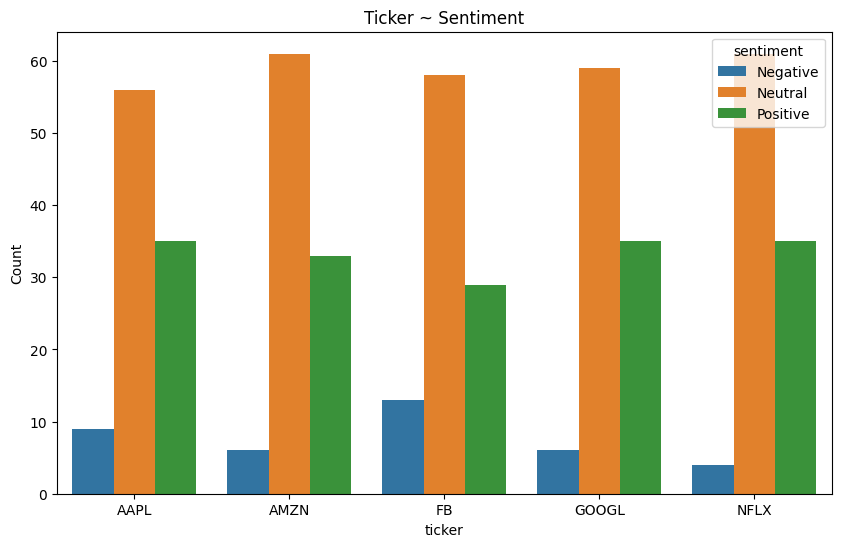

In [12]:
# ticker vs sentiment
tick_by_sent = data.groupby(['ticker', 'sentiment']).size().reset_index(name = 'Count')
print(tick_by_sent)
plt.figure(figsize = (10,6))
sns.barplot(x = 'ticker', y = 'Count', hue = 'sentiment', data = tick_by_sent)
plt.title("Ticker ~ Sentiment")
plt.show()

In [13]:
# preparing data
X = TfidfVectorizer(max_features=5000, ngram_range=(1, 1)).fit_transform(data['clean_headline']).toarray()
y = data['sentiment'].values

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print(X_train.shape)
print(y_train.shape)

(375, 1251)
(375,)


In [14]:

# SMOTE for data balancing
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

#Chose not to use SMOTE because of overfitting risk

In [15]:

# train and evaluate model
models = [
    DecisionTreeClassifier(),
    LogisticRegression(max_iter=1000),
    MultinomialNB(),
    KNeighborsClassifier(),
    RandomForestClassifier(n_estimators=100, random_state=43),
    SVC(kernel='linear')
]

models_dict = {
    0: "Decision Tree", 
    1: "Logistic Regression", 
    2: "Naive Bayes", 
    3: "K-Neighbors", 
    4: "Random Forest", 
    5: "SVC"
}

for i, model in enumerate(models):
    try:
        cv_results = cross_val_score(model, X_train, y_train, cv=10, scoring="accuracy")
        print(f"{models_dict[i]} Test Accuracy: {cv_results.mean():.4f}")
    except Exception as e:
        print(f"Error in {models_dict[i]}: {e}")


Decision Tree Test Accuracy: 0.8695
Logistic Regression Test Accuracy: 0.7841
Naive Bayes Test Accuracy: 0.7760
K-Neighbors Test Accuracy: 0.6827
Random Forest Test Accuracy: 0.8401
SVC Test Accuracy: 0.8320


Decision tree is the best model with highest accuracy

In [16]:
# hyperparameter tuning
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': [None, 'balanced']
}

grid_dt = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=43),
    param_grid=param_grid_dt,
    scoring='accuracy',
    cv=5,
    verbose=3,
    n_jobs=-1
)

grid_dt.fit(X_train, y_train)

print("best parameters:", grid_dt.best_params_)
print("best accuracy: {:.2f}%".format(grid_dt.best_score_ * 100))


Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV 2/5] END class_weight=None, criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=0.853 total time=   0.0s
[CV 3/5] END class_weight=None, criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=0.840 total time=   0.0s
[CV 1/5] END class_weight=None, criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=0.840 total time=   0.0s
[CV 1/5] END class_weight=None, criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=10;, score=0.853 total time=   0.0s
[CV 3/5] END class_weight=None, criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=10;, score=0.827 total time=   0.0s
[CV 2/5] END class_weight=None, criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=10;, score=0.853 total time=   0.0s
[CV 4/5] END class_weight=None, criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=10;, score

In [17]:
# evaluate on test data with best params
best_dt = DecisionTreeClassifier(**grid_dt.best_params_, random_state=43)
best_dt.fit(X_train, y_train)
predictions_dt = best_dt.predict(X_test)

accuracy_dt = accuracy_score(y_test, predictions_dt)
print("Test Accuracy: {:.2f}%".format(accuracy_dt * 100))


Test Accuracy: 89.60%


In [18]:
# classification report
print("Classification Report for Decision Tree:")
print(classification_report(y_test, predictions_dt))

Classification Report for Decision Tree:
              precision    recall  f1-score   support

    Negative       1.00      0.40      0.57        10
     Neutral       0.92      0.96      0.94        81
    Positive       0.83      0.88      0.86        34

    accuracy                           0.90       125
   macro avg       0.92      0.75      0.79       125
weighted avg       0.90      0.90      0.89       125



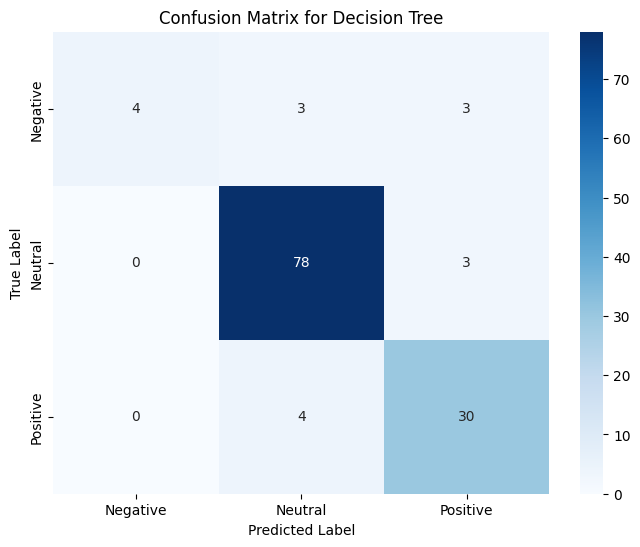

In [19]:
# confusion matrix
confusion_dt = confusion_matrix(y_test, predictions_dt)

# plot
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_dt, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title("Confusion Matrix for Decision Tree")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
